# Power price validation
Routines for price validation comprising
* Comparison of price statistics
* Comparison of price patterns
* Comparison of negative price and scarcity price events
* Calculation of error metrics (MAE, RSME)

## Package imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pommesevaluation.price_validation import (
    read_and_reshape_historical_prices, compare_negative_price_distribution,
    draw_price_plot, draw_weekly_plot, draw_price_duration_plot, calculate_error_metrics
)

## Set parameters
Specify path and filenames where data is stored:
* Power price results from the model.
* Historical day-ahead prices (used for validation)

In [2]:
simulation_year = 2017
path_results = "./model_results/"
path_plots = "./plots/"
path_historical_prices = "./data/prices/"

model_file_name = f"dispatch_LP_start-{simulation_year}-01-01_364-days_simple_complete_power-prices.csv"

## Read in data
* Historical prices for years from 2017 to 2021 (simulate year used for validation)
* Model prices for the respective simulation year

In [3]:
historical_prices_fnames = {
    2017: f"{path_historical_prices}auction_spot_prices_germany_austria_2017.csv",
    2018: [
        f"{path_historical_prices}auction_spot_prices_germany_austria_2018.csv", 
        f"{path_historical_prices}auction_spot_prices_germany_luxembourg_2018.csv"
    ]
}

for year in range(2019, 2022):
    historical_prices_fnames[year] = f"{path_historical_prices}auction_spot_prices_germany_luxembourg_{year}.csv"
    
historical_prices = dict()

for year, file_name in historical_prices_fnames.items():
    historical_prices[year] = read_and_reshape_historical_prices(year, file_name)

In [4]:
model_prices = pd.read_csv(
    path_results + model_file_name, sep=",", decimal=".", index_col = 0, infer_datetime_format=True
)
model_prices.index = pd.to_datetime(model_prices.index)
model_prices = model_prices.rename(columns={"Power price":"model_price"})

## Visualize historical prices and calculate some statistics
* Plot power prices for years 2017 to 2021
* Calculate summary statistics for all years

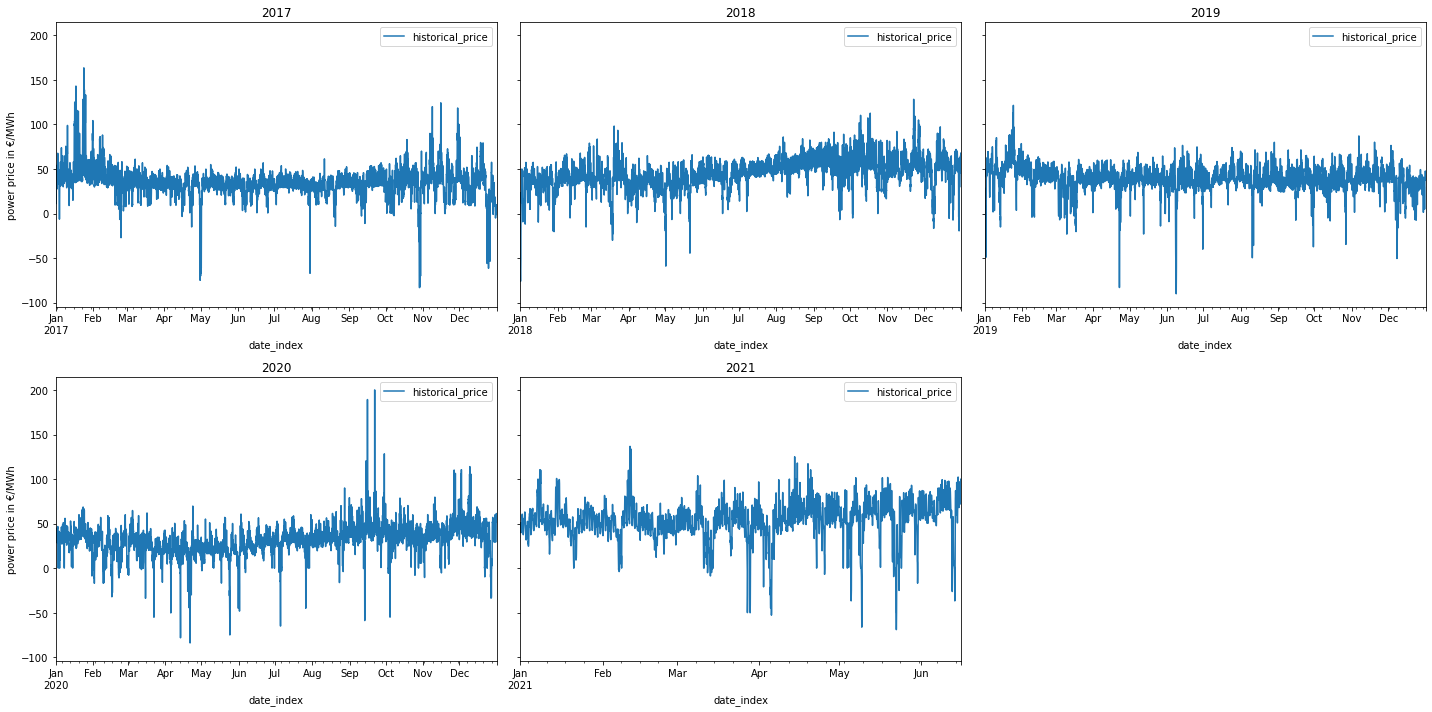

In [5]:
loc_map = {
    2017: (0, 0),
    2018: (0, 1),
    2019: (0, 2),
    2020: (1, 0),
    2021: (1, 1),
}

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), sharey=True)

for key, val in historical_prices.items():
    val.plot(ax=axes[loc_map[key]])
    axes[loc_map[key]].set_title(key)

fig.delaxes(axes[1, 2])
axes[0, 0].set_ylabel("power price in €/MWh")
axes[1, 0].set_ylabel("power price in €/MWh")
plt.tight_layout()
plt.show()

In [6]:
stats_df = pd.DataFrame(index=historical_prices[2017].describe().index, columns=range(2017, 2022))
stats_df.loc["negative_hours"] = 0
stats_df.loc["scarcity_hours"] = 0

for key, val in historical_prices.items():
    stats_df[key] = val.describe()
    stats_df.at["negative_hours", key] = val.loc[val["historical_price"] < 0].count()
    stats_df.at["scarcity_hours", key] = val.loc[val["historical_price"] == 3000].count()
    
stats_df

,2017,2018,2019,2020,2021
count,8760.000000,8760.000000,8760.0000,8784.000000,3983.000000
mean,34.188527,44.468920,37.6666,30.470716,52.525898
std,17.659501,17.771203,15.5175,17.500845,22.073974
min,-83.060000,-76.010000,-90.0100,-83.940000,-69.000000
25%,27.780000,34.455000,31.0600,21.750000,43.330000
50%,33.825000,45.090000,38.0600,30.990000,53.800000
75%,40.570000,54.870000,46.2700,40.250000,64.925000
max,163.520000,128.260000,121.4600,200.040000,136.710000
negative_hours,146.000000,134.000000,211.0000,298.000000,105.000000
scarcity_hours,0.000000,0.000000,0.0000,0.000000,0.000000


# Validate model results with historical prices
Model results for a historical year are evaluated against historical day-ahead prices.
* Summary statistics are calculated for comparison.
* Negative price distributions are compared against each other.
* The annual price time series and duration curves are plotted against each other.
* Weekly price time series are written to disk.
* Mean average error (note: for evaluating estimates for the median) and root mean squared error (note: for evaluating estimates for the mean value) are evaluated.

## Compare summary statistics

In [7]:
stats_comparison_df = pd.DataFrame(index=stats_df.index, columns=["historical", "model"])

stats_comparison_df["historical"] = historical_prices[year].describe()
stats_comparison_df["model"] = model_prices.describe()
stats_comparison_df.at["negative_hours", "historical"] = historical_prices[year].loc[historical_prices[year].historical_price < 0].count()
stats_comparison_df.at["negative_hours", "model"] = model_prices.loc[model_prices.model_price < 0].count()
stats_comparison_df.at["scarcity_hours", "historical"] = historical_prices[year].loc[historical_prices[year].historical_price == 3000].count()
stats_comparison_df.at["scarcity_hours", "model"] = model_prices.loc[model_prices.model_price == 3000].count()

stats_comparison_df

,historical,model
count,3983.000000,8760.000000
mean,52.525898,22.276102
std,22.073974,12.557904
min,-69.000000,-80.056649
25%,43.330000,16.725104
50%,53.800000,21.471717
75%,64.925000,26.835611
max,136.710000,94.250733
negative_hours,105.000000,123.000000
scarcity_hours,0.000000,0.000000


## Compare negative price distribution

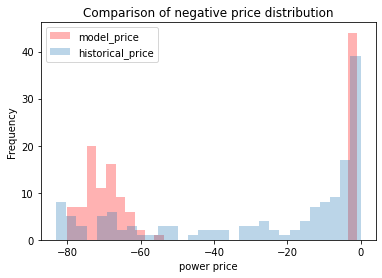

In [8]:
compare_negative_price_distribution(model_prices, historical_prices, simulation_year)

## Compare annual and weekly prices against eacht other

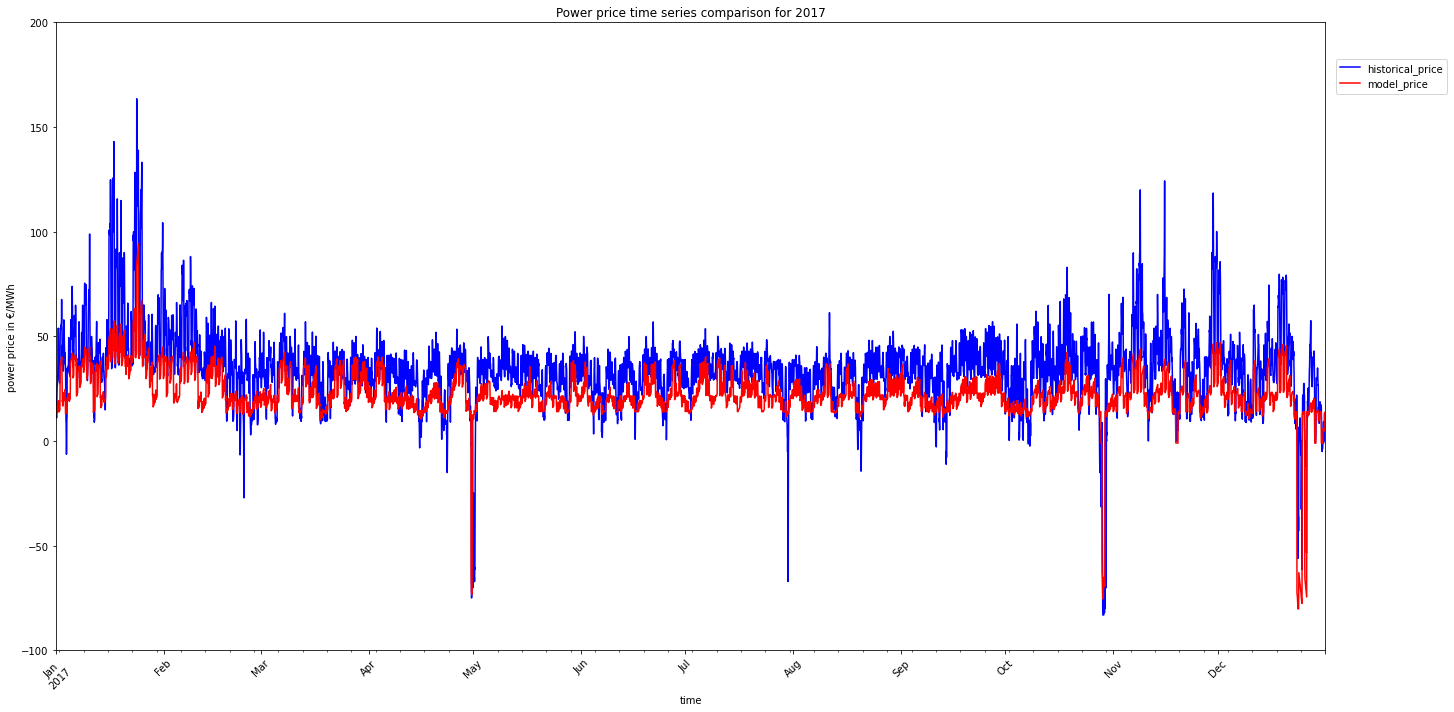

In [9]:
# Concatenate model results and historical ones
prices = pd.concat([historical_prices[simulation_year], model_prices], axis=1)

draw_price_plot(
    power_prices=prices, 
    color=["b", "r"],
    title=f"Power price time series comparison for {simulation_year}",
    y_min_max=True,
    show=True,
    save=True,
    file_name=f"power_price_time_series_{simulation_year}"
)

In [10]:
draw_weekly_plot(prices, simulation_year)

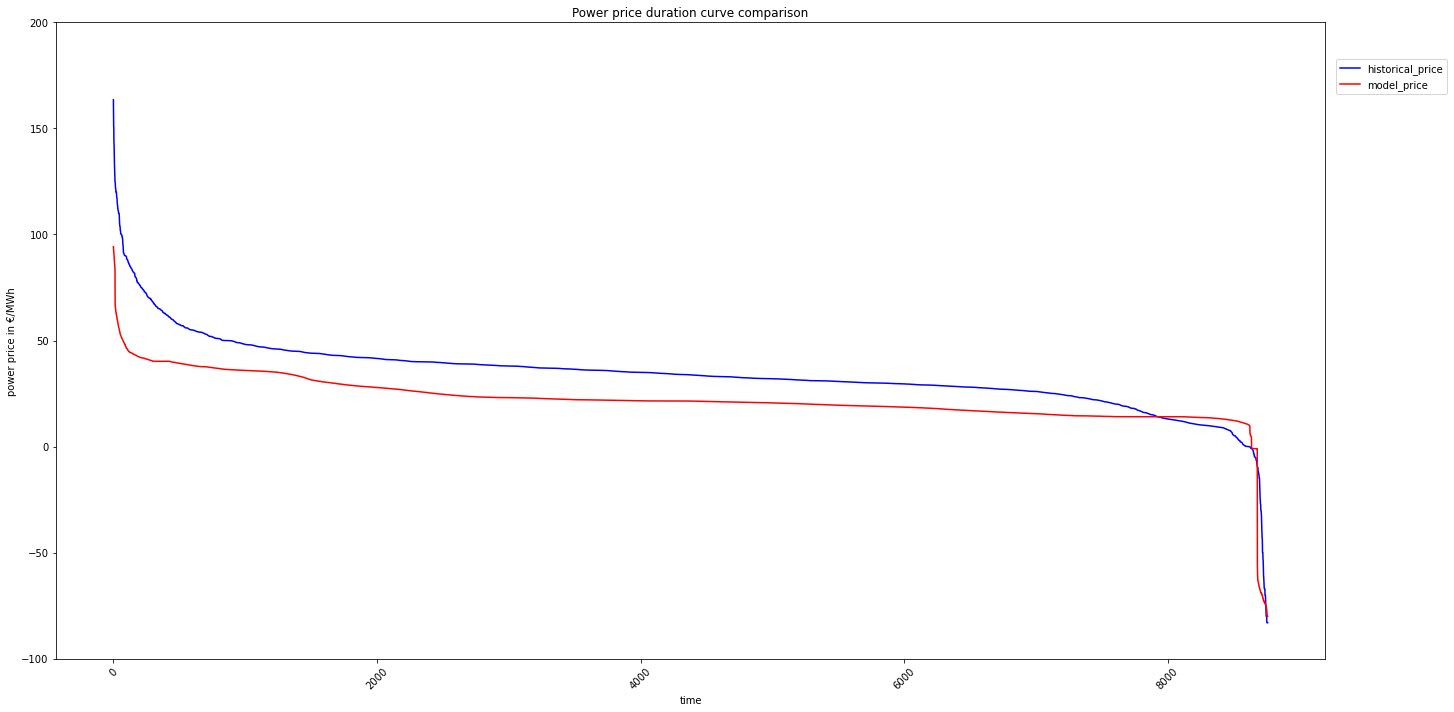

In [11]:
draw_price_duration_plot(
    model_prices, historical_prices[simulation_year], show=True, save=True, file_name=f"power_price_duration_curve_{simulation_year}"
)

## Calculate error values
Calculate mean absolute and root mean squared error for model to get an impression on model results quality

In [12]:
error_metrics = calculate_error_metrics(historical_prices[simulation_year], model_prices)
print("Mean absolute error for model results: {:.2f} \nRoot mean squared error for model results: {:.2f}".format(error_metrics["MAE"], error_metrics["RMSE"]))

Mean absolute error for model results: 13.20 
Root mean squared error for model results: 16.50
